In [1]:
import os
import sys 
import numpy as np
import matplotlib.pyplot as plt
import sys 
import mdtraj
from nglview import show_ase, show_file, show_mdtraj
import torch

import ase
from ase import Atoms
from ase.constraints import FixBondLengths
from ase.calculators.tip3p import TIP3P, rOH, angleHOH
from ase.md import Langevin
import ase.units as units
from ase.io.trajectory import Trajectory
import numpy as np

from scripts.infer_topology import generate_subgraphs

from scripts.pretrain import pretrain_aimd

_ColormakerRegistry()

In [2]:
device = 3

size = 4 

n_mols = 4 ** 3

from ase.geometry import wrap_positions

box = np.load('../data/water_aimd/box_0.npy').reshape(-1,  3, 3)
xyz = np.load('../data/water_aimd/coord_0.npy').reshape(-1, n_mols * 3, 3)

atoms = Atoms(positions=xyz[0], cell=box[0])
z =  [8] * 64 + [1] * 64 * 2 

positions = wrap_positions(xyz[0], box[0])
atoms.set_positions(positions)
atoms.set_atomic_numbers(z)

from torchmd.system import System
system = System(atoms, device=device)

In [3]:
show_ase(system)

NGLWidget()

In [4]:
size = 4

bond_top = [ [ i,  i + 64 * j] for i in range(64) for j in range(1, 3)]
bond_top = torch.LongTensor(bond_top)

angle_top = [[i + 64, i,  i + 64 * 2] for i in range(64)]
angle_top = torch.LongTensor(angle_top)

hh_tuple = [[i + 64,  i + 64 * 2] for i in range(64)]
hh_tuple = torch.LongTensor(hh_tuple)

In [5]:
system.set_temperature(298.0)

In [6]:
from torchmd.system import AnglePotentials, BondPotentials, Electrostatics

KCAL_TO_EV = 4.3363e-2

k_bond =  450 * KCAL_TO_EV 
k_angle = 55 * KCAL_TO_EV 

bondenergy = BondPotentials(system, bond_top, k_bond, rOH)
angleenergy = AnglePotentials(system, angle_top, k_angle, angleHOH * np.pi / 180 )

charges = torch.Tensor( [-0.834, 0.417, 0.417] * (size ** 3) )
coulomb = Electrostatics(charges, system.get_cell_len(), device=device,
                                cutoff=6, index_tuple=None, ex_pairs=torch.cat((hh_tuple, bond_top), dim=0))

# get atom type index
o_index = [i for i in range(size ** 3)]
h_index = [i + size ** 3 for i in range(size ** 3 * 2)]

In [7]:
from nff.data import Dataset, split_train_validation_test, collate_dicts, sparsify_tensor
from nff.train import Trainer, get_trainer, get_model, loss, hooks, metrics, evaluate
import nff.data as d
from torch.utils.data import DataLoader

In [15]:
from torchmd.system import GNNPotentials, GNNPotentialsTrain, PairPotentials,System, Stack
from torchmd.potentials import ExcludedVolume, LennardJones
from nff.train import get_model

params = {
    'n_atom_basis': 256,
    'n_filters': 256,
    'n_gaussians': 32,
    'n_convolutions': 3,
    'cutoff': 4.5,
    'trainable_gauss': False
}

epsilon_scale = 0.02
sigma_scale = 1.0

pair_oo = PairPotentials(LennardJones, {'epsilon': epsilon_scale * 0.1521 * KCAL_TO_EV, 'sigma': 3.15 * sigma_scale},
                cell=torch.Tensor(system.get_cell_len()), 
                device=device,
                index_tuple=(o_index, o_index),
                cutoff=6.0,
                ).to(device)

pair_oh = PairPotentials(LennardJones, {'epsilon': epsilon_scale * 0.086 * KCAL_TO_EV, 'sigma': 1.77 * sigma_scale},
                cell=torch.Tensor(system.get_cell_len()), 
                device=device,
                index_tuple=(o_index, h_index),
                ex_pairs=bond_top,
                cutoff=6.0,
                ).to(device)

pair_hh = PairPotentials(LennardJones, {'epsilon': epsilon_scale * 0.046 * KCAL_TO_EV, 'sigma': 0.4 * sigma_scale},
                cell=torch.Tensor(system.get_cell_len()), 
                device=device,
                index_tuple=(h_index, h_index),
                ex_pairs=hh_tuple,
                cutoff=6.0,
                ).to(device)

schnet = get_model(params)

tensor([12.4447, 12.4447, 12.4447])
tensor([12.4447, 12.4447, 12.4447])
tensor([12.4447, 12.4447, 12.4447])


In [19]:
prior = Stack({
               'pair_oo': pair_oo,
               'pair_oh': pair_oh, 
               'pair_hh': pair_hh, 
               'angle': angleenergy, 
               'bond': bondenergy,
               #'coulomb': coulomb
                })

In [70]:
model = GNNPotentialsTrain(schnet, prior,
                         system.get_batch(), system.get_cell_len(), 
                         device=system.device)

# Train a NN 
model = pretrain_aimd(model, system, device, params['cutoff'], './water/', 20)

building dataset
 Time | Epoch | Learning rate | Train loss | Validation loss | MAE_energy_grad | GPU Memory (MB)
23:30 |    22 |     5.000e-04 |     0.0115 |          0.0086 |          0.0722 |               0
23:52 |    23 |     5.000e-04 |     0.0144 |          0.0096 |          0.0769 |               0
24:16 |    24 |     5.000e-04 |     0.0109 |          0.0088 |          0.0735 |               0
24:38 |    25 |     5.000e-04 |     0.0101 |          0.0082 |          0.0708 |               0
25:01 |    26 |     5.000e-04 |     0.0093 |          0.0080 |          0.0704 |               0
25:24 |    27 |     5.000e-04 |     0.0089 |          0.0080 |          0.0701 |               0
25:47 |    28 |     5.000e-04 |     0.0086 |          0.0079 |          0.0698 |               0
26:10 |    29 |     5.000e-04 |     0.0093 |          0.0080 |          0.0699 |               0
26:33 |    30 |     5.000e-04 |     0.0085 |          0.0079 |          0.0695 |               0
26:56 |    31

In [71]:
dataset = build_data(atoms, 1, params['cutoff'])

building dataset


In [72]:
loader = DataLoader(dataset, batch_size=1, collate_fn=collate_dicts)

In [73]:

loss_fn = loss.build_mse_loss(loss_coef={'energy_grad': 1})
results, targets, val_loss = evaluate(model, loader, loss_fn, device=device)


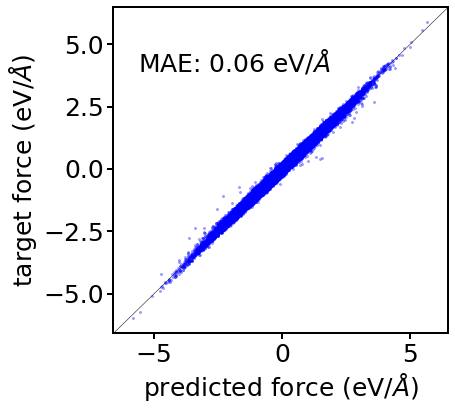

In [74]:
units_dict = {
    'energy_grad': r'eV/$\AA$',
}

key = 'energy_grad'

plt.figure(figsize=(6,6))

pred = torch.stack(results[key], dim=0).view(-1).detach().cpu().numpy()
targ = torch.stack(targets[key], dim=0).view(-1).detach().cpu().numpy()
mae = abs(pred-targ).mean()

plt.scatter(pred, targ, color='blue', alpha=0.3, s=4)

lim_min = min(np.min(pred), np.min(targ)) * 1.1
lim_max = max(np.max(pred), np.max(targ)) * 1.1

plt.xlim(lim_min, lim_max)
plt.ylim(lim_min, lim_max)

plt.plot((lim_min, lim_max),
        (lim_min, lim_max),
        color='#000000',
        zorder=-1,
        linewidth=0.5)

plt.xlabel('predicted %s (%s)' % ("force", units_dict[key]))
plt.ylabel('target %s (%s)' % ("force", units_dict[key]))
    
#     ax.set_title(key.upper(), fontsize=14)
#     ax.set_xlabel('predicted %s (%s)' % (key, units[key]), fontsize=12)
#     ax.set_ylabel('target %s (%s)' % (key, units[key]), fontsize=12)
plt.text(0.1, 0.9, 'MAE: %.2f %s' % (mae, units_dict[key]), 
           transform=ax.transAxes)
    
plt.show()

In [75]:
from scipy import interpolate

oo_start = 2.25
oo_end = 5.75
oh_start = 1.25
oh_end = 5.75
hh_start = 1.0
hh_end = 5.75
nbins = 60
rdf_smear_width = 0.1

def get_exp_rdf(data, nbins, r_range, obs):
    # load RDF data 
    f = interpolate.interp1d(data[:,0], data[:,1])
    start = r_range[0]
    end = r_range[1]
    xnew = np.linspace(start, end, nbins)

    # make sure the rdf data is normalized
    V = (4/3)* np.pi * (end ** 3 - start ** 3)
    g_obs = torch.Tensor(f(xnew)).to(obs.device)
    g_obs_norm = ((g_obs.detach() * obs.vol_bins).sum()).item()
    g_obs = g_obs * (V/g_obs_norm)
    count_obs = g_obs * obs.vol_bins / V

    return count_obs, g_obs

In [76]:
from torchmd.md import NoseHooverChain, Simulations
from torchmd.observable import rdf

cutoff = params['cutoff']
# Build GNN for simulation 
GNN = GNNPotentials(model.gnn_module, 
                    system.get_batch(), 
                    system.get_cell_len(),
                     cutoff=cutoff, 
                     device=system.device,
                     )

# define simulator with 
FF = Stack({
       'gnn': GNN,
       'pair_oo': pair_oo,
       'pair_oh': pair_oh, 
       'pair_hh': pair_hh, 
       'angle': angleenergy, 
       'bond': bondenergy
    })

diffeq = NoseHooverChain(FF, 
        system,
        Q=50.0, 
        T=298.0 * units.kB,
        num_chains=5, 
        adjoint=True).to(device)

sim = Simulations(system, diffeq, wrap=True)

# Set up observable 
obs_oo = rdf(system, nbins=nbins, r_range=(oo_start, oo_end), index_tuple=(o_index, o_index), width=rdf_smear_width)
obs_oh = rdf(system, nbins=nbins, r_range=(oh_start, oh_end), index_tuple=(o_index, h_index), width=rdf_smear_width)
obs_hh = rdf(system, nbins=nbins, r_range=(hh_start, hh_end), index_tuple=(h_index, h_index), width=rdf_smear_width)

# initialize observable function 
data_oo = np.load("../data/water_exp_pccp.npy")
data_oh = np.load("../data/water_exp_jcp_oh.npy")
data_hh = np.load("../data/water_exp_jcp_hh.npy")

count_obs, g_oo_data = get_exp_rdf(data_oo, nbins, (oo_start, oo_end), obs_oo)
count_obs, g_oh_data = get_exp_rdf(data_oh, nbins, (oh_start, oh_end), obs_oh)
count_obs, g_hh_data = get_exp_rdf(data_hh, nbins, (hh_start, hh_end), obs_hh)

In [85]:
sim_trajs = []
del diffeq.traj
for i in range(80):
    _, q_t, _ = sim.simulate(steps=25, frequency=25, dt=1.0 * units.fs)
    sim_trajs.append(q_t[-1].detach().cpu().numpy())

In [87]:
sim_trajs = torch.Tensor(np.array(sim_trajs)).to(device)

_, _, g_oo =  obs_oo(sim_trajs[::1])
_, _, g_oh =  obs_oh(sim_trajs[::1])
_, _, g_hh =  obs_hh(sim_trajs[::1])

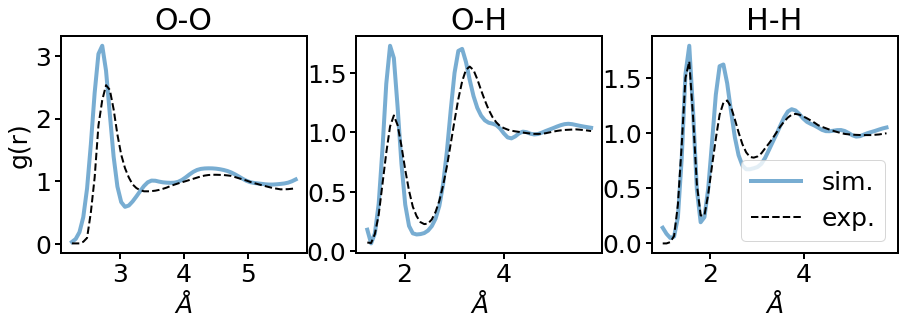

In [88]:
from scripts.gnn_rdf_aa import plot_all

plot_all(g_oo, g_oo_data, (oo_start, oo_end),
         g_oh, g_oh_data, (oh_start, oh_end),
         g_hh, g_hh_data, (hh_start, hh_end),
         nbins, 
         './water/', 
         fname="final" )

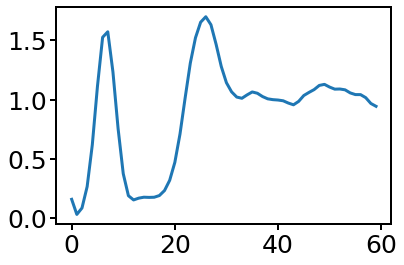

In [57]:
sim_trajs = torch.Tensor(np.array(sim_trajs)).to(device)
test_loss = get_test_loss(sim_trajs)

In [55]:
_, _, goo = obs_oo(q_t)

_, _, goh = obs_oh(q_t)


In [114]:
from utils import display_traj

In [115]:
view = display_traj(system, diffeq.traj)
view.representations = [
    {"type": "spacefill", "params": {'radius':0.85
    }}]

In [116]:
view

NGLWidget(max_frame=9)

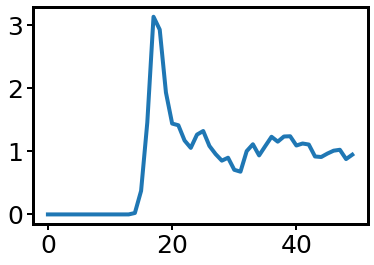

In [124]:
plt.plot(goo.detach().cpu().numpy())

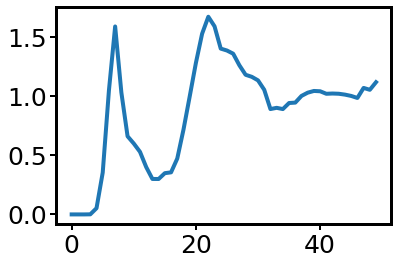

In [125]:
plt.plot(goh.detach().cpu().numpy())

In [36]:
import matplotlib
matplotlib.rcParams.update({'font.size': 25})
matplotlib.rc('lines', linewidth=3, color='g')
matplotlib.rcParams['axes.linewidth'] = 2.0
matplotlib.rcParams['axes.linewidth'] = 2.0
matplotlib.rcParams["xtick.major.size"] = 6
matplotlib.rcParams["ytick.major.size"] = 6
matplotlib.rcParams["ytick.major.width"] = 2
matplotlib.rcParams["xtick.major.width"] = 2
matplotlib.rcParams['text.usetex'] = False


In [67]:

mem_brute = [12.9424384, 36.198707199999994, 73.69267199999999, 111.18899199999998, 148.685312, 186.18163199999998, 373.6544256, 748.5878272, 1498.4551424, 3748.9672192]
mem_ad = [11.506585599999998, 11.542527999999999, 11.591168, 11.639807999999999, 
          11.688448, 11.737088, 11.981311999999999, 12.469759999999999, 13.447168, 16.37888, 22.462566399999996, 36.781158399999995]
t_brute = [2, 5, 10, 15, 20, 25, 50, 100, 200, 500]
t_ad = [2, 5, 10, 15, 20, 25, 50, 100, 200, 500, 1000, 2000]

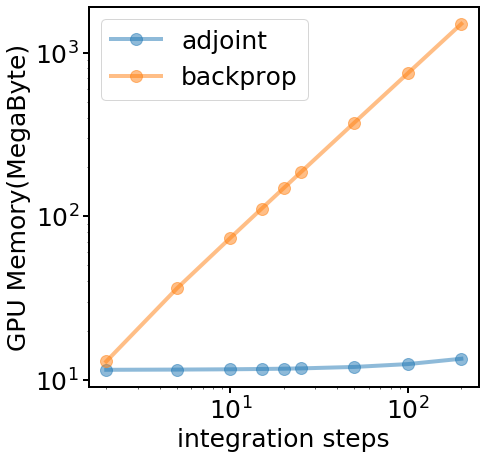

In [86]:
plt.figure(figsize=(7,7))
plt.plot(t_ad[:9], mem_ad[:9], linewidth=4, alpha=0.5, marker='o', markersize=12, label='adjoint')
plt.plot(t_brute[:9], mem_brute[:9], linewidth=4, alpha=0.5, marker='o', markersize=12, label='backprop')

#plt.plot(np.array(t_brute), np.array(t_brute))
plt.xscale("log")
plt.yscale("log")

plt.ylabel("GPU Memory(MegaByte)")

plt.xlabel("integration steps")

plt.legend()
plt.show()

In [79]:
system.get_number_of_atoms()

192

In [ ]:
# test 